# Fourier-Spectral Interpolation

> _h/t Steve DeWitt (ORNL) for the concept and Daniel Wheeler (NIST) for the derivation_

We have data $v$ on a coarse mesh $\mathrm{X}$ that we wish to compare to a gold standard field $u$ on a fine mesh $\mathrm{Y}$.  
This is simplest to implement by zero-padding the Fourier-transformed data $\hat{v}$ to match the shape of $\mathrm{Y}$, then transforming back to real space.  
Conceptually, this involves some work.

> _N.B.:_
> 1. Regardless of the simulation domain, the interpolation domain spans $\left[0, 2\pi\right]$.
> 2. The interpolation domain must be periodic; in the summations over real space, the first point
>    $(j=0)$ is skipped, since the last point $(j=N)$ provides its full value.

## Coarse Data

Consider field values $v$ embedded on the mesh $\mathrm{X}$:

| index _j_ | 0     | 1     | $\cdots$ | _N_   |
| ---       | ---   | ---   | ---      | ---   |
| coord     | $x_0$ | $x_1$ | $x_j$    | $x_N$ |
| value     | $v_0$ | $v_1$ | $v_j$    | $v_N$ |

where $x_j$ takes values on $\left[0, 2\pi\right]$ and the uniform spacing between points is $h = \frac{2\pi}{N}$.

The forward transform of $v$ is

$$ \hat{v}_k = \sum\limits_{j=1}^{N} e^{-\mathrm{i}kx_j}\, v_j $$

and the reverse transform of $\hat{v}$ is

$$ v_j = \frac{h}{2\pi} \sum\limits_{k=-\frac{N}{2}}^{\frac{N}{2}-1} e^{\mathrm{i}kx_j}\, \hat{v}_k $$

We also have the interpolation function approximating $v_j$:

$$ f(\xi) = \frac{h}{2\pi} \sum\limits_{k=-\frac{N}{2}}^{\frac{N}{2}-1} e^{\mathrm{i}k\xi}\, \hat{v}_k $$

## Fine Mesh

Now consider a finer mesh $\mathrm{Y}$ with empty values $u$:

| index _p_ | 0     | 1     | 2     | 3     | 4     | $\cdots$ | _M_-1     | _M_   |
| ---       | ---   | ---   | ---   | ---   | ---   | ---      |  ---      | ---   |
| coord     | $y_0$ | $y_1$ | $y_2$ | $y_3$ | $y_4$ | $y_p$    | $y_{M-1}$ | $y_M$ |
| value     | $u_0$ | $u_1$ | $u_2$ | $u_3$ | $u_4$ | $u_p$    | $u_{M-1}$ | $u_M$ |

where $y_p$ takes values on $\left[0, 2\pi\right]$ and the uniform spacing between points is $\ell = \frac{2\pi}{M}$ with $M>N$.

The reverse transform of $\hat{u}$ is

$$ u_p = \frac{\ell}{2\pi} \sum\limits_{k'=-\frac{M}{2}}^{\frac{M}{2}-1} e^{\mathrm{i}k' y_p}\, \hat{u}_{k'} $$

and the forward transform of $u$ is

$$ \hat{u}_{k'} = \sum\limits_{p=1}^{M} e^{-\mathrm{i}k'y_p}\, u_p $$

## Clever Tricks

Now, let's substitute our interpolant $f(y_p)$ for $u_p$ in the forward transformation:

$$ \hat{u}_{k'} = \sum\limits_{p=1}^{M} e^{-\mathrm{i}k'y_p} \left\{ \frac{h}{2\pi} \sum\limits_{k=-\frac{N}{2}}^{\frac{N}{2}-1} e^{\mathrm{i}ky_p}\, \hat{v}_k \right\} $$

Factoring out the constants and changing the order of summation, noting that $\hat{v}_k$ is independent of the real-space index $p$,

$$ \hat{u}_{k'} = \frac{h}{2\pi} \sum\limits_{k=-\frac{N}{2}}^{\frac{N}{2}-1} \hat{v}_k \sum\limits_{p=1}^{M} e^{\mathrm{i}(k - k')y_p} $$

Now, recognizing the Kronecker delta function

$$ \delta_{k - k'} = \frac{1}{M} \sum\limits_{p=1}^{M} e^{-\mathrm{i}(k - k')y_p} $$

and substituting, along with $\frac{h}{2\pi}=\frac{1}{N}$, we have

$$ \hat{u}_{k'} = \frac{M}{N} \sum\limits_{k=-\frac{N}{2}}^{\frac{N}{2}-1} \hat{v}_k \delta_{k - k'} $$

$$ \hat{u}_{k'} = \begin{cases}
\frac{M}{N} \hat{v}_k, & -\frac{N}{2} \leq k' \leq \frac{N}{2}-1 \\
0, & \mathrm{otherwise.}\\
\end{cases} $$

## Illustrative Example (1D)

Take a coarse grid with $N=4$ points and a fine grid with $M=8$ points. Then

| $k'$ | $-4$ | $-3$ | $-2$ | $-1$ | $0$ | $1$ | $2$ | $3$ |
| ---  | ---  | ---  | ---  | ---  | --- | --- | --- | --- |
| $\hat{u}_{k'}$ | $0$ | $0$ | $\frac{M}{N}\hat{v}_0$ | $\frac{M}{N}\hat{v}_1$ | $\frac{M}{N}\hat{v}_2$ | $\frac{M}{N}\hat{v}_3$ | $0$ | $0$ |

So, Fourier interpolation of coarse data onto the fine mesh requires

0. $M$ and $N$ must be even integers
1. Transform the coarse data of size $N$ to get $\hat{v}_k$
2. Zero-pad the transformed data, centering it in a reciprocal-space mesh of size $M$
3. Scale the padded transformed values by $\frac{M}{N}$ to get $\hat{u}_{k'}$
4. Take the reverse Fourier transform to get $u_p$

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

L = 2 * np.pi

def pad(v_hat, M):
    """
    Zero-pad "before and after" coarse data to fit fine mesh size

    Keyword arguments:
    v_hat -- the Fourier-transformed field data to pad
    M -- the length (1D) or shape (2D+) of the fine mesh
    """
    N = v_hat.shape
    z = np.subtract(M, N, dtype=int) // 2  # equiv. (M - N) // 2
    z = z.reshape((len(N), 1))
    return np.pad(v_hat, z)


def fourier_interpolation(v, M):
    """
    Interpolate the coarse field data $v$ onto a mesh of shape $M$
    """
    v_hat = np.fft.fftshift(np.fft.fftn(v))
    u_hat = pad(v_hat, np.flip(M))  # transpose (x, y): this will break in 3D atm.
    scale = np.prod(np.array(u_hat.shape)) / np.prod(np.array(v.shape))
    u = scale * np.fft.ifftn(np.fft.ifftshift(u_hat)).real
    return u


def data1D(N):
    """
    Create synthetic data $v$ of size $N$ using a periodic function on [0, 2π)
    """
    x = np.linspace(0, L - L/N, N)
    v = np.exp(np.sin(x))
    return x, v


def data2D(N):
    """
    Create synthetic data $v$ of shape $N$ using a periodic function on [0, 2π)×[0,2π)
    """
    X = np.linspace(0, L - L/N[0], N[0])
    Y = np.linspace(0, L - L/N[1], N[1])
    x, y = np.meshgrid(X, Y, indexing="xy")
    v = np.exp(np.sin(x - np.pi/2 * np.cos(y)))
    return v


def side_by_side(title, coarse, refined):
    fig, ax = plt.subplots(1, 2, figsize=(10,4), constrained_layout=True)
    fig.suptitle(title)
    ax[0].set_title("coarse");
    fig.colorbar(ax[0].imshow(coarse, cmap="coolwarm", origin="lower", interpolation=None));
    ax[1].set_title("refined")
    fig.colorbar(ax[1].imshow(refined, cmap="coolwarm", origin="lower", interpolation=None));

# 1D test

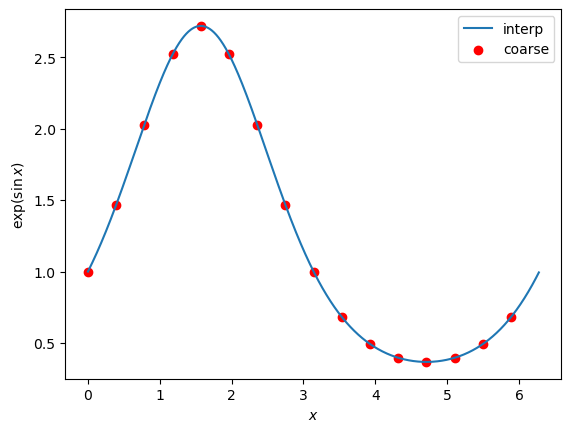

In [2]:
N1 = 16
x, v1 = data1D(N1)

M1 = 1024
y, U1 = data1D(M1)

u1 = fourier_interpolation(v1, M1)

plt.plot(y, u1, label="interp");
plt.scatter(x, v1, label="coarse", color="red");
plt.xlabel("$x$");
plt.ylabel("$\\exp(\\sin x)$");
plt.legend(loc="best");

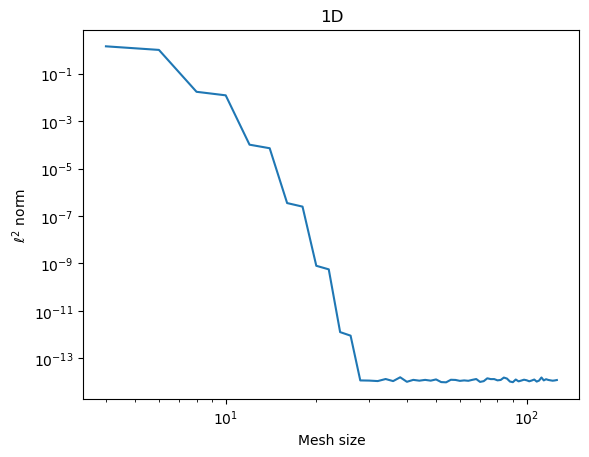

In [3]:
N1s = np.arange(4, M1//8, 2)
Z1s = []

for N1 in N1s:
    x, v1 = data1D(N1)
    u1 = fourier_interpolation(v1, M1)
    Z1s += [np.linalg.norm(u1 - U1)]

plt.loglog(N1s, Z1s);
plt.title("1D");
plt.xlabel("Mesh size");
plt.ylabel("$\\ell^2$ norm");

## 2D test

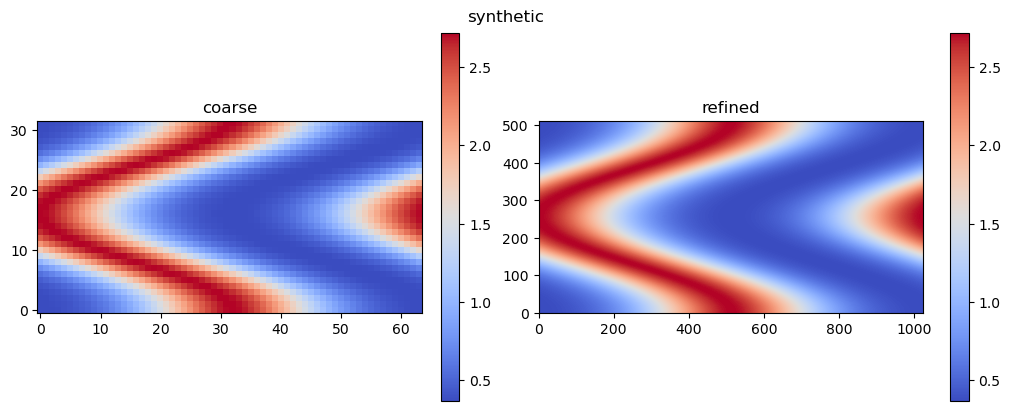

In [4]:
N2 = (64, 32)
v2 = data2D(N2)

M2 = (1024, 512)
u2 = fourier_interpolation(v2, M2)

side_by_side("synthetic", v2, u2)

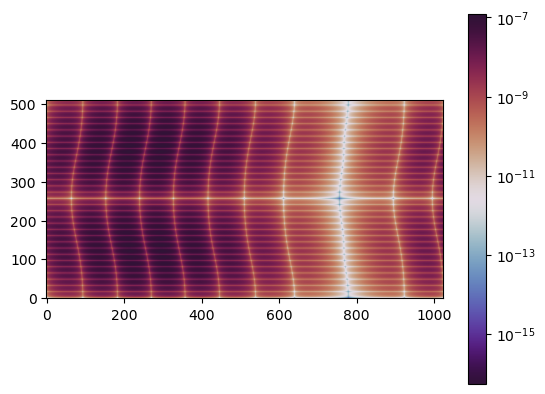

In [5]:
U2 = data2D(M2)

plt.colorbar(plt.imshow(np.absolute(u2 - U2), norm="log", cmap="twilight_shifted", origin="lower", interpolation=None));

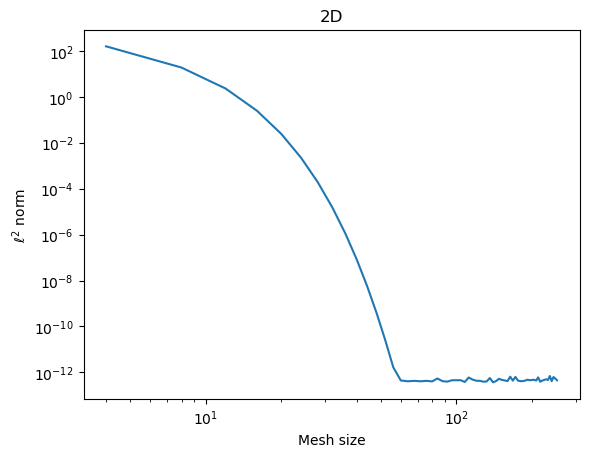

In [6]:
N2s = np.arange(4, M2[0]//4, 4)
Z2s = []

for N in N2s:
    N2 = (N, N)
    v2 = data2D(N2)
    u2 = fourier_interpolation(v2, M2)
    Z2s += [np.linalg.norm(u2 - U2)]

plt.loglog(N2s, Z2s);
plt.title("2D");
plt.xlabel("Mesh size");
plt.ylabel("$\\ell^2$ norm");

### "Real" data

The synthetic function is nice, but PFHub data is not. Give that a whirl.

In [7]:
# Spinodal decomposition parameters
Lx = 200.
Ly = 200.

ζ = 0.5    # mean composition
ϵ = 0.01   # noise amplitude

hf = 0.0625  # fine resolution
hc = 0.1250  # coarse resolution

Nf = (np.rint(Lx / hf).astype(int), np.rint(Ly / hf).astype(int))
Nc = (np.rint(Lx / hc).astype(int), np.rint(Ly / hc).astype(int))

xc = np.linspace(0., Lx - Lx/Nc[0], Nc[0])
yc = np.linspace(0., Ly - Ly/Nc[1], Nc[1])
Xc, Yc = np.meshgrid(xc, yc, indexing="xy")

xf = np.linspace(0., Lx - Lx/Nf[0], Nf[0])
yf = np.linspace(0., Ly - Ly/Nf[1], Nf[1])
Xf, Yf = np.meshgrid(xf, yf, indexing="xy")

# not-random microstructure
ripples = lambda x, y, A, B: np.cos(A[0] * x) * np.cos(B[0] * y) \
                           +(np.cos(A[1] * x) * np.cos(B[1] * y)) ** 2 \
                           + np.cos(A[2] * x - B[2] * y) \
                           * np.cos(A[3] * x - B[3] * y)

ℓ² = 7.752e-01


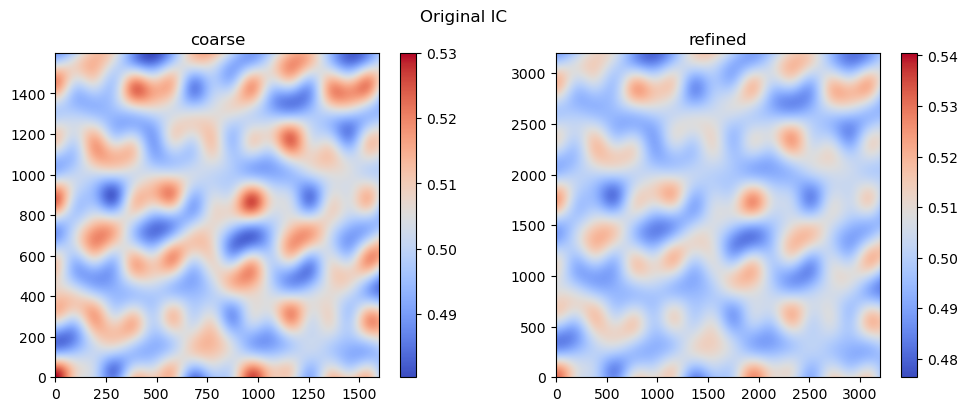

In [8]:
# published cosine coefficients
A0 = np.array([0.105, 0.130, 0.025, 0.070])
B0 = np.array([0.110, 0.087, 0.150, 0.020])

ic_orig = lambda x, y: ζ + ϵ * ripples(x, y, A0, B0)

cfo = ic_orig(Xf, Yf)
cco = ic_orig(Xc, Yc)
ufo = fourier_interpolation(cco, Nf)
l2o = np.linalg.norm(cfo - ufo)
print(f"ℓ² = {l2o:.3e}")

side_by_side("Original IC", cco, ufo)

ℓ² = 3.832e-13


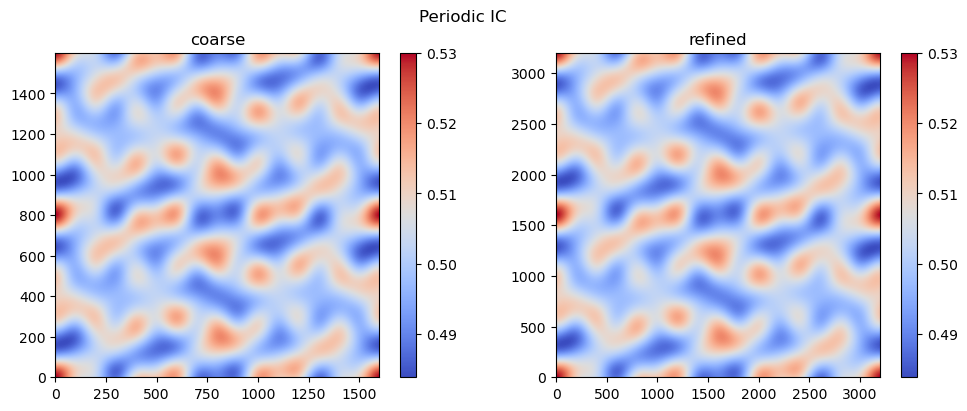

In [9]:
# periodic cosine coefficients
Ap = np.pi / Lx * np.array([6.0, 8.0, 2.0, 4.0])
Bp = np.pi / Ly * np.array([8.0, 6.0, 10., 2.0])

ic_peri = lambda x, y: ζ + ϵ * ripples(x, y, Ap, Bp)

cfp = ic_peri(Xf, Yf)
ccp = ic_peri(Xc, Yc)
ufp = fourier_interpolation(ccp, Nf)
l2p = np.linalg.norm(cfp - ufp)
print(f"ℓ² = {l2p:.3e}")

side_by_side("Periodic IC", ccp, ufp)

## Window functions

### _tl;dr:_ use the Hann window!

We can "force" the published IC to become smooth and continuous on the boundary by applying a [window function](https://en.wikipedia.org/wiki/Window_function#A_list_of_window_functions).
The "tophat" below is my naïve design, the remainder have better theoretical foundations.

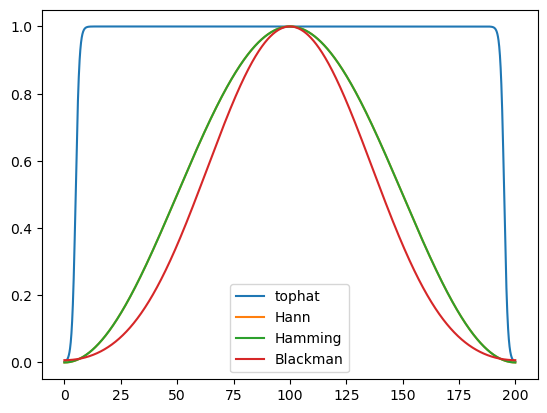

In [10]:
λ = Lx / 40 # width of periodic boundary shell

# tophat window -- touches y=0
tophat = lambda x, L: 0.25 * (1 + np.tanh(np.pi * (x - λ) / λ)) \
                           * (1 + np.tanh(np.pi * (L - x - λ) / λ))

# hann window -- touches y=0
hann = lambda x, L: 0.5 * (1 - np.cos(2 * np.pi * x / L))

# hamming window -- does not touch y=0
hamming = lambda x, L: 25/46 - (1 - 25/46) * np.cos(2 * np.pi * x / L)

# blackman window -- does not touch y=0
blackman = lambda x, L: 7938/18608 - 9240/18608 * np.cos(2 * np.pi * x / L) + 1430/18608 * np.cos(4 * np.pi * x / L)

plt.plot(xf, tophat(xf, Lx), label="tophat");
plt.plot(xf, hann(xf, Lx), label="Hann");
plt.plot(xf, hann(xf, Lx), label="Hamming");
plt.plot(xf, blackman(xf, Lx), label="Blackman");
plt.legend(loc="best");

ℓ² = 1.350e-03


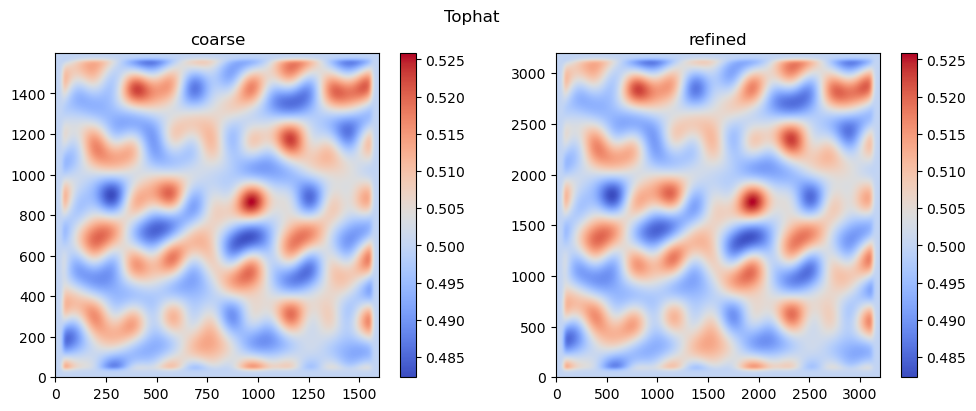

In [11]:
ic_phat = lambda x, y: ζ + ϵ * tophat(x, Lx) * tophat(y, Ly) * ripples(x, y, A0, B0)

cft = ic_phat(Xf, Yf)
cct = ic_phat(Xc, Yc)
uft = fourier_interpolation(cct, Nf)
l2t = np.linalg.norm(cft - uft)
print(f"ℓ² = {l2t:.3e}")

side_by_side("Tophat", cct, uft)

ℓ² = 1.688e-07


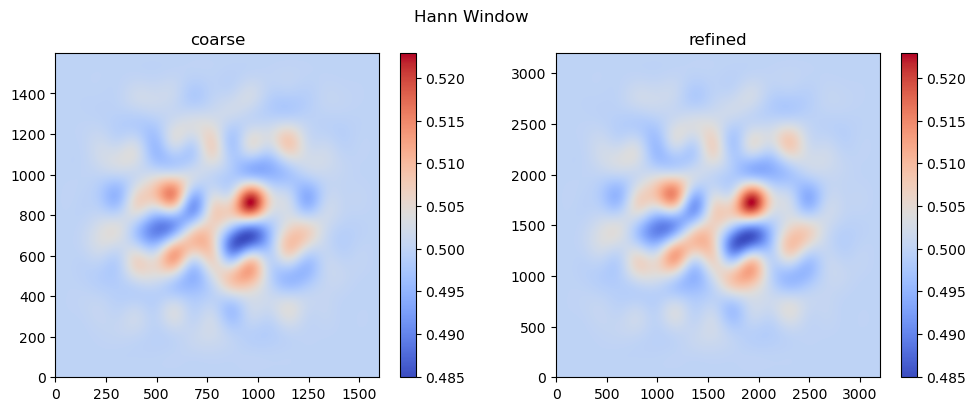

In [12]:
ic_hann = lambda x, y: ζ + ϵ * hann(x, Lx) * hann(y, Ly) * ripples(x, y, A0, B0)

cfh = ic_hann(Xf, Yf)
cch = ic_hann(Xc, Yc)
ufh = fourier_interpolation(cch, Nf)
l2h = np.linalg.norm(cfh - ufh)
print(f"ℓ² = {l2h:.3e}")

side_by_side("Hann Window", cch, ufh)

ℓ² = 1.688e-07


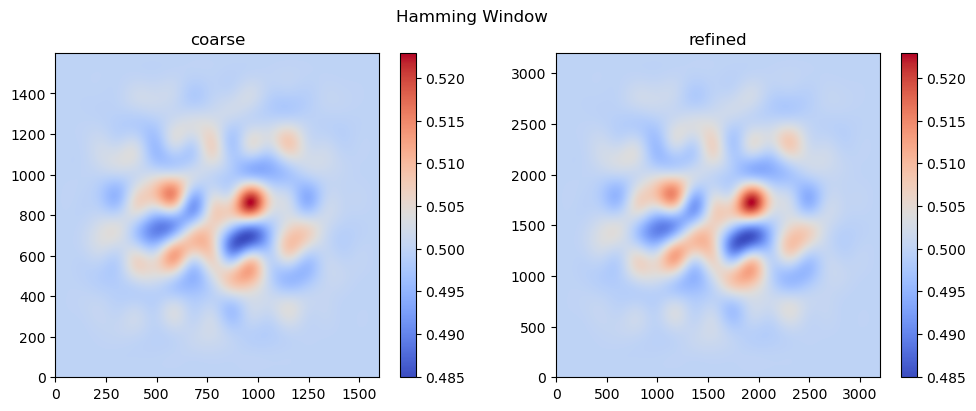

In [13]:
ic_hamm = lambda x, y: ζ + ϵ * hann(x, Lx) * hann(y, Ly) * ripples(x, y, A0, B0)

cfm = ic_hamm(Xf, Yf)
ccm = ic_hamm(Xc, Yc)
ufm = fourier_interpolation(ccm, Nf)
l2m = np.linalg.norm(cfm - ufm)
print(f"ℓ² = {l2m:.3e}")

side_by_side("Hamming Window", ccm, ufm)

ℓ² = 3.009e-03


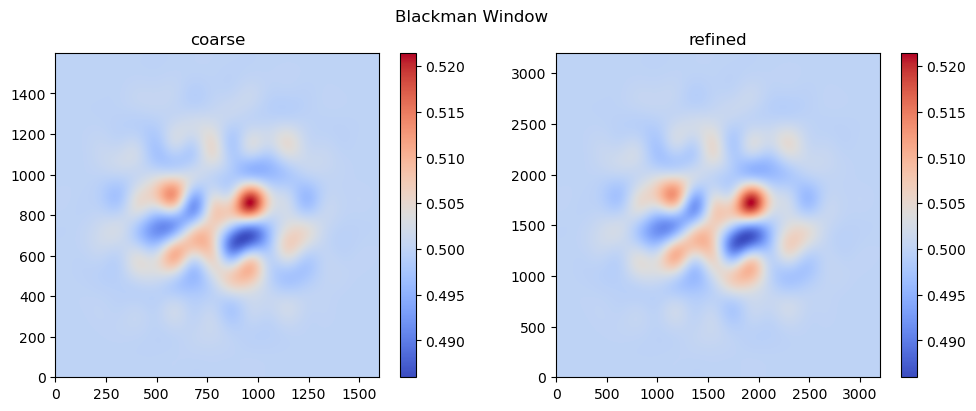

In [14]:
ic_blac = lambda x, y: ζ + ϵ * blackman(x, Lx) * blackman(y, Ly) * ripples(x, y, A0, B0)

cfb = ic_blac(Xf, Yf)
ccb = ic_blac(Xc, Yc)
ufb = fourier_interpolation(ccb, Nf)
l2b = np.linalg.norm(cfb - ufb)
print(f"ℓ² = {l2b:.3e}")

side_by_side("Blackman Window", ccb, ufb)

### Hann-Hybridized Periodic IC

What if we use the Hann window to combine the continuous and discontinuous ICs?

ℓ² = 1.688e-07


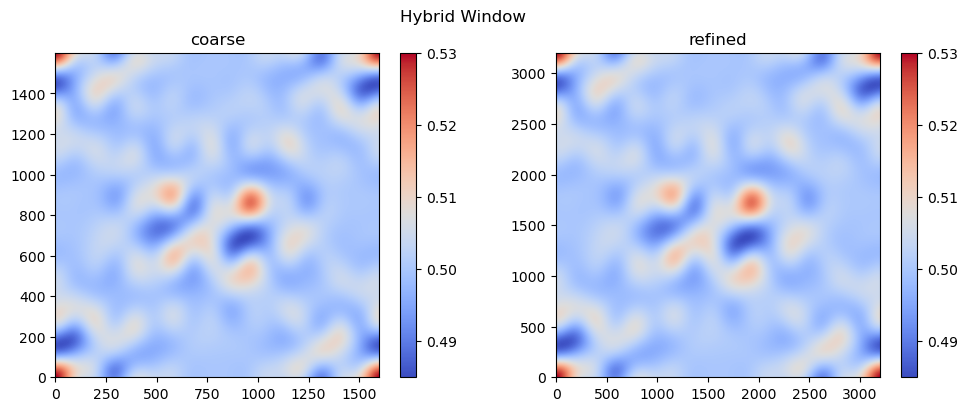

In [15]:
sin_win = lambda x, y, Lx, Ly: hann(x, Lx) * hann(y, Ly)
cos_win = lambda x, y, Lx, Ly: (1 - hann(x, Lx)) * (1 - hann(y, Ly))

ic_hybr = lambda x, y: ζ + ϵ * (sin_win(x, y, Lx, Ly) * ripples(x, y, A0, B0) 
                              + cos_win(x, y, Lx, Ly) * ripples(x, y, Ap, Bp))

cfx = ic_hybr(Xf, Yf)
ccx = ic_hybr(Xc, Yc)
ufx = fourier_interpolation(ccx, Nf)
l2x = np.linalg.norm(cfx - ufx)
print(f"ℓ² = {l2x:.3e}")

side_by_side("Hybrid Window", ccx, ufx)

## Window Summary

The periodic IC is "best" in terms of spectral convergence.

Using the Hann window to hybridize the periodic and original ICs preserves interesting features.

| IC       | ℓ²        |
| ---      | ---       |
| periodic | 3.832e-13 |
| hybrid   | 1.688e-07 |
| Hann     | 1.688e-07 |
| tophat   | 1.350e-03 |
| Blackman | 3.009e-03 |
| Hamming  | 4.287e-02 |
| original | 7.752e-01 |


## Fourier Transform with Phase Shift

Directly computing the $\ell_2$ norm between microstructures is incredibly sensitive to discretization errors. What if we carry out the analysis in reciprocal space?

ℓ² = 4.383e+00


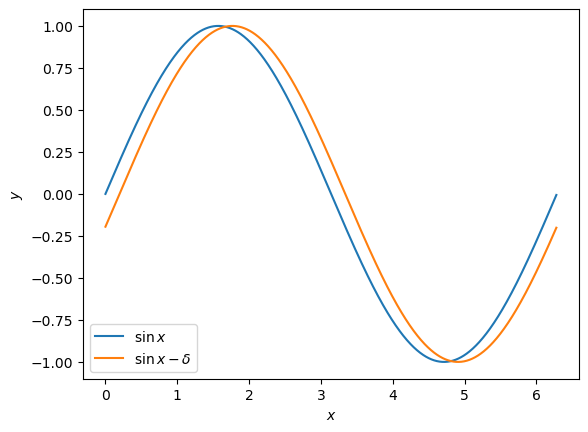

In [106]:
n = 1
δ = np.pi/16
x0 = np.linspace(0, L, 1000, endpoint=False)

y0 = np.sin(2 * n * np.pi / L * x0)
y1 = np.sin(2 * n * np.pi / L * (x0 - δ))

plt.plot(x0, y0, label="$\\sin x$");
plt.plot(x0, y1, label="$\\sin x-\\delta$");
plt.xlabel("$x$");
plt.ylabel("$y$");
plt.legend(loc=3);

print(f"ℓ² = {np.linalg.norm(y0-y1):.3e}")

ℓ² = 1.386e+02


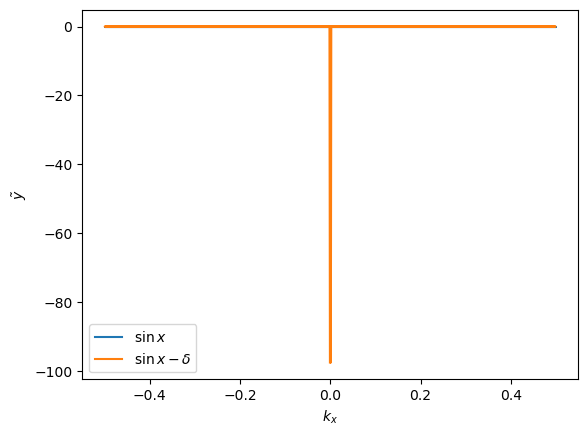

In [107]:
kx0 = np.fft.fftfreq(len(x0));
ky0 = np.fft.fftn(y0)
ky1 = np.fft.fftn(y1)

plt.plot(kx0, ky0, label="$\\sin x$");
plt.plot(kx0, ky1, label="$\\sin x-\\delta$");
plt.xlabel("$k_x$");
plt.ylabel("$\\tilde{y}$");
# plt.yscale("asinh");
plt.legend(loc=3);

print(f"ℓ² = {np.linalg.norm(ky0-ky1):.3e}")

r.ℓ² = 1.379e+02 i.ℓ² = 1.359e+01


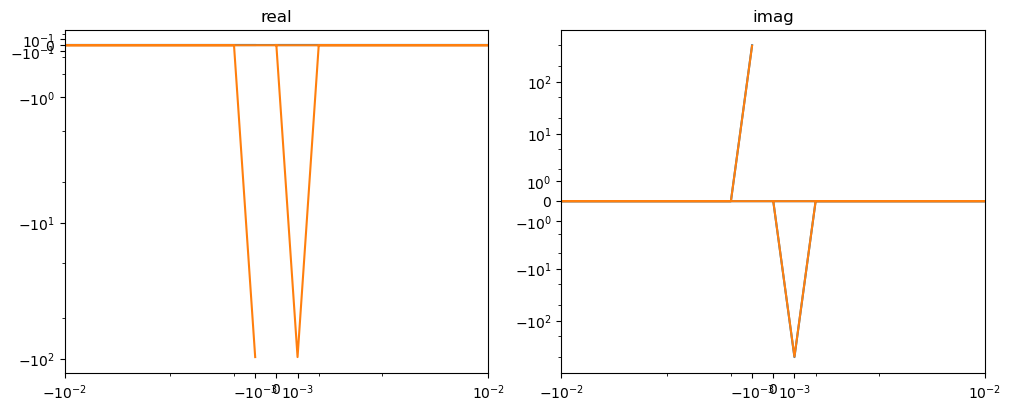

In [108]:
fig, ax = plt.subplots(1, 2, figsize=(10,4), constrained_layout=True, sharex=True)

ax[0].set_title("real");
ax[0].set_xscale("asinh");
ax[0].set_yscale("asinh");
ax[0].set_xlim([-0.01, 0.01]);
ax[0].plot(kx0, ky0.real, label="$\\sin x$");
ax[0].plot(kx0, ky1.real, label="$\\sin x-\\delta$");

ax[1].set_title("imag")
ax[1].set_xscale("asinh");
ax[1].set_yscale("asinh");
ax[1].plot(kx0, ky0.imag, label="$\\sin x$");
ax[1].plot(kx0, ky1.imag, label="$\\sin x-\\delta$");


print(f"r.ℓ² = {np.linalg.norm(ky0.real-ky1.real):.3e}",
      f"i.ℓ² = {np.linalg.norm(ky0.imag-ky1.imag):.3e}")

## power spectra

ℓ² = 6.517e-11


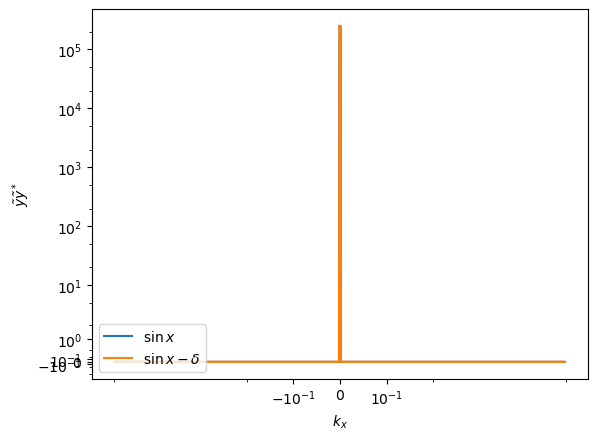

In [109]:
kx0 = np.fft.fftfreq(len(x0));
ky0 = np.fft.fftn(y0)
ky1 = np.fft.fftn(y1)

ps0 = ky0 * np.conjugate(ky0)
ps1 = ky1 * np.conjugate(ky1)

plt.plot(kx0, ps0, label="$\\sin x$");
plt.plot(kx0, ps1, label="$\\sin x-\\delta$");
plt.xlabel("$k_x$");
plt.ylabel("$\\tilde{y} \\tilde{y}^*$");
plt.yscale("asinh");
plt.xscale("asinh");
plt.legend(loc=3);

print(f"ℓ² = {np.linalg.norm(ps0-ps1):.3e}")

ℓ² = 6.517e-11


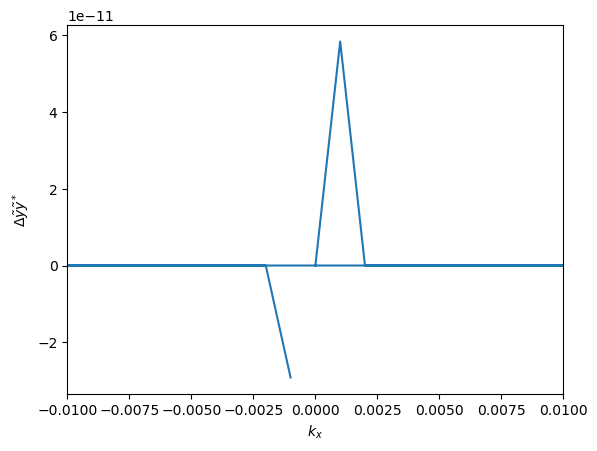

In [110]:
plt.plot(kx0, ps1 - ps0);
plt.xlabel("$k_x$");
plt.ylabel("$\\Delta \\tilde{y} \\tilde{y}^*$");
# plt.xscale("asinh");
# plt.yscale("asinh");
plt.xlim(-0.01, 0.01);

print(f"ℓ² = {np.linalg.norm(ps0-ps1):.3e}")

ℓ² = 1.598e-12


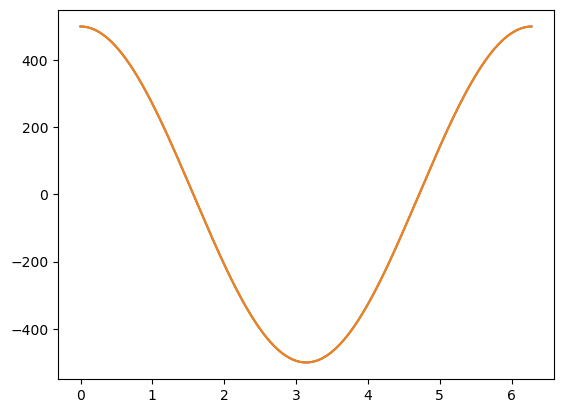

In [111]:
tp0 = np.fft.ifftn(ps0).real
tp1 = np.fft.ifftn(ps1).real

plt.plot(x0, tp0);
plt.plot(x0, tp1);

print(f"ℓ² = {np.linalg.norm(tp1 - tp0):.3e}")

## Take-Away

All righty. Taking the ℓ² norm of microstructures is far too sensitive to offsets. Taking the FFT, generating the power spectrum ($\tilde{y}\tilde{y}^*$), and finally creating the two-point correlation by transforming back to real space is the way to go next. Higher-order correlations may be helpful, but require correlations in Fourier space, so, let's start with two-point/autocorrelation.